### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /share/costeffectiveness/results/vivarium_nih_us_cvd/cause_model_only/alabama/2023_03_17_11_45_13/count_data

deaths.csv  state_person_time.csv  transition_count.csv  ylds.csv  ylls.csv
deaths.hdf  state_person_time.hdf  transition_count.hdf  ylds.hdf  ylls.hdf


In [5]:
sim_results_dir = '/share/costeffectiveness/results/vivarium_nih_us_cvd/cause_model_only/alabama/2023_03_17_11_45_13/count_data/'

### Exploring Data

In [6]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [5]:
#pop = pd.read_csv(sim_results_dir + 'population.csv')
#pop.loc[pop.measure=="total_population_untracked"].value.sum()
#pop.head()

In [7]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [8]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

101155892.61054072

In [10]:
state_person_time.state.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_heart_failure_residual',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure',
       'ischemic_stroke_acute_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke'], dtype=object)

In [11]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
person_time_test.value.sum()

101155892.6105407

### Total DALYs by Year

In [12]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,female,25_to_29,29,2023,2465.950662,36.120516,2502.071178
1,female,25_to_29,29,2024,1651.603917,34.878387,1686.482304
2,female,25_to_29,29,2025,1597.083294,34.965326,1632.048620
3,female,25_to_29,29,2026,1778.664262,34.992147,1813.656409
4,female,25_to_29,29,2027,1843.566422,35.244049,1878.810471


In [13]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,6390.417169,941.341639,13791.324364
1,2024,6473.187771,830.919328,13985.914112
2,2025,6494.966639,905.346911,14274.151007
3,2026,6550.725860,857.022864,14039.279034
4,2027,6602.316060,835.757909,14599.356639


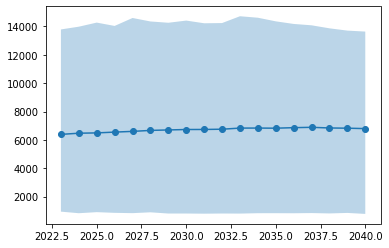

In [14]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [15]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,3.8125,0.0,17.075
1,25_to_29,female,2024,3.4500,0.0,18.000
2,25_to_29,female,2025,3.5125,0.0,14.050
3,25_to_29,female,2026,3.0750,0.0,15.000
4,25_to_29,female,2027,3.7250,0.0,17.025


In [16]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('model11vv_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [17]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27467.214237
1,25_to_29,female,2023,232,27811.263518
2,25_to_29,female,2023,357,27640.848734
3,25_to_29,female,2023,394,27483.006160
4,25_to_29,female,2023,602,27448.969199


In [18]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001106,0.000849,0.001422
1,25_to_29,female,2024,0.001012,0.000744,0.001439
2,25_to_29,female,2025,0.001039,0.000754,0.001420
3,25_to_29,female,2026,0.000915,0.000665,0.001336
4,25_to_29,female,2027,0.001111,0.000802,0.001653


In [19]:
%%capture 
with PdfPages('model11_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [20]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('model11_acmr_by_year.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [21]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.0,0.0,0.0
1,8,25_to_29,female,2024,acute_ischemic_stroke,0.0,0.0,0.0
2,16,25_to_29,female,2025,acute_ischemic_stroke,0.3,0.0,1.0
3,24,25_to_29,female,2026,acute_ischemic_stroke,0.0,0.0,0.0
4,32,25_to_29,female,2027,acute_ischemic_stroke,0.0,0.0,0.0


In [22]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,0
1,8,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,16,25_to_29,female,2023,357,acute_ischemic_stroke,0
3,24,25_to_29,female,2023,394,acute_ischemic_stroke,0
4,32,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [23]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.0,0.000000
1,25_to_29,female,2024,0.000000,0.0,0.000000
2,25_to_29,female,2025,0.000011,0.0,0.000037
3,25_to_29,female,2026,0.000000,0.0,0.000000
4,25_to_29,female,2027,0.000000,0.0,0.000000


In [24]:
%%capture 
with PdfPages('model11_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [25]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.008971,0.002673,0.019749
537,95_plus,male,2038,0.008702,0.002367,0.017737
538,95_plus,male,2039,0.008540,0.002877,0.015636
539,95_plus,male,2040,0.007407,0.002492,0.012506


In [26]:
%%capture
with PdfPages('model11_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [27]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [132]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000042,0.0,0.000145
1,25_to_29,female,2024,0.000048,0.0,0.000183
2,25_to_29,female,2025,0.000052,0.0,0.000167
3,25_to_29,female,2026,0.000041,0.0,0.000169
4,25_to_29,female,2027,0.000048,0.0,0.000151


In [60]:
%%capture
with PdfPages('model11_acute_MI_csmr.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [61]:
%%capture
with PdfPages('model11_acute_MI_csmr_byyear.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for age in acute_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [62]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000091,0.000036,0.000146
1,25_to_29,female,2024,0.000070,0.000000,0.000139
2,25_to_29,female,2025,0.000104,0.000037,0.000177
3,25_to_29,female,2026,0.000033,0.000000,0.000103
4,25_to_29,female,2027,0.000075,0.000037,0.000199


In [63]:
%%capture
with PdfPages('model11_post_MI_csmr.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [64]:
%%capture
with PdfPages('model11_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [66]:
## Possibly climbing in the oldest age groups

#### Heart Failure

In [67]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000256,0.0,0.000799
1,25_to_29,female,2024,0.000218,0.0,0.000704
2,25_to_29,female,2025,0.000209,0.0,0.000556
3,25_to_29,female,2026,0.000199,0.0,0.000539
4,25_to_29,female,2027,0.000257,0.0,0.000711


In [70]:
%%capture
with PdfPages('model11_HF_csmr.pdf') as pdf:
    for sex in HF_rate_summ.sex.unique():
        for year in HF_rate_summ.year.unique():
            plt.figure() 
            subdata = HF_rate_summ.loc[(HF_rate_summ.sex==sex) & (HF_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'HF CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            #plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [72]:
state_person_time['state'].unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_heart_failure_residual',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure',
       'ischemic_stroke_acute_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke'], dtype=object)

In [73]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.064353,0.023154,0.106962
1,25_to_29,female,2024,0.054582,0.000000,0.130318
2,25_to_29,female,2025,0.074572,0.023404,0.119252
3,25_to_29,female,2026,0.025605,0.000000,0.075249
4,25_to_29,female,2027,0.053858,0.025085,0.160847


In [74]:
%%capture
with PdfPages('model11_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Heart Failure EMR

In [221]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.796162,0.0,5.237926
1,25_to_29,female,2024,1.110541,0.0,8.410362
2,25_to_29,female,2025,0.734668,0.0,4.123537
3,25_to_29,female,2026,1.314087,0.0,8.946924
4,25_to_29,female,2027,1.251610,0.0,5.762710


In [222]:
%%capture
with PdfPages('model11_HF_emr.pdf') as pdf:
    for sex in HF_emr_summ.sex.unique():
        for year in HF_emr_summ.year.unique():
            plt.figure() 
            subdata = HF_emr_summ.loc[(HF_emr_summ.sex==sex) & (HF_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'HF EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [75]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000009,2.764617e-06,0.000018
1,25_to_29,female,2024,0.000011,3.429751e-06,0.000022
2,25_to_29,female,2025,0.000009,6.337528e-07,0.000024
3,25_to_29,female,2026,0.000008,2.828258e-06,0.000023
4,25_to_29,female,2027,0.000009,6.454759e-07,0.000016


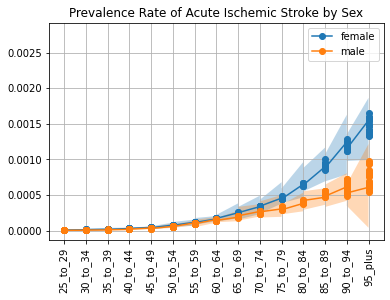

In [76]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [77]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

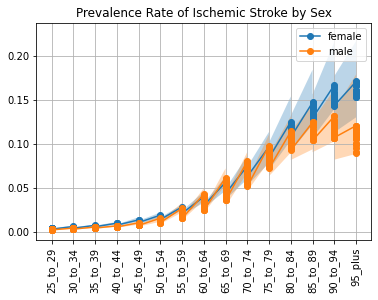

In [78]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [271]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000030,0.000017,0.000050
1,25_to_29,female,2024,0.000038,0.000026,0.000053
2,25_to_29,female,2025,0.000030,0.000014,0.000047
3,25_to_29,female,2026,0.000035,0.000020,0.000054
4,25_to_29,female,2027,0.000034,0.000019,0.000052


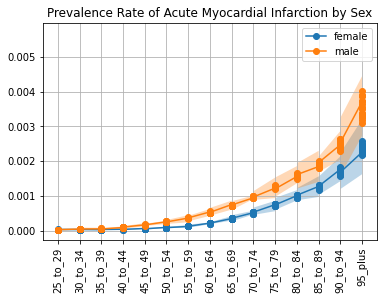

In [272]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [81]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001439,0.001080,0.001734
1,25_to_29,female,2024,0.001406,0.001071,0.001697
2,25_to_29,female,2025,0.001420,0.001030,0.001867
3,25_to_29,female,2026,0.001397,0.001009,0.001894
4,25_to_29,female,2027,0.001403,0.001062,0.001925


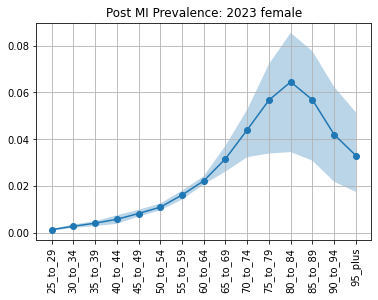

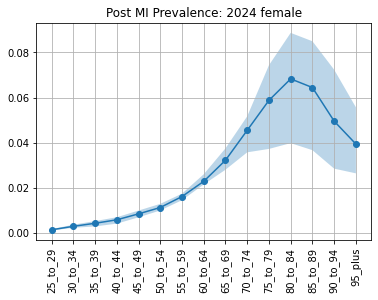

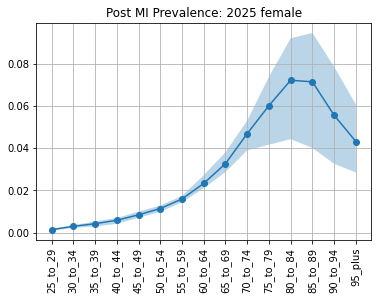

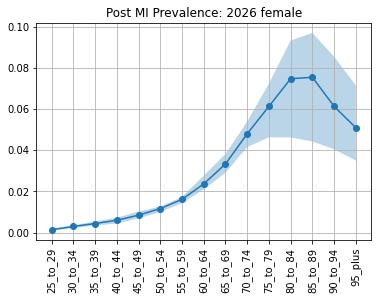

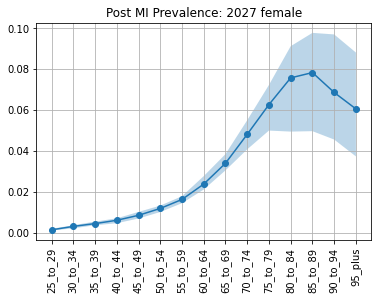

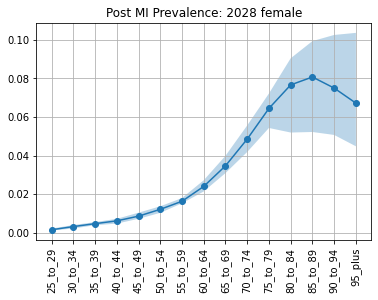

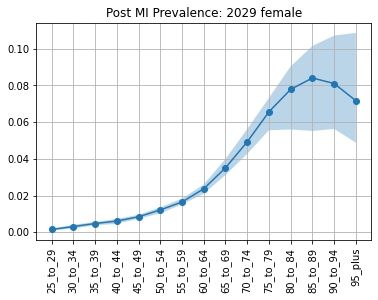

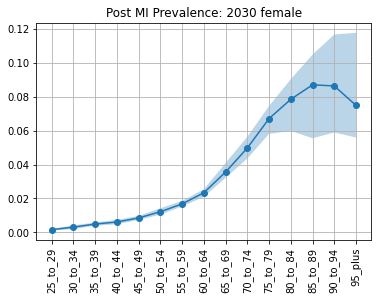

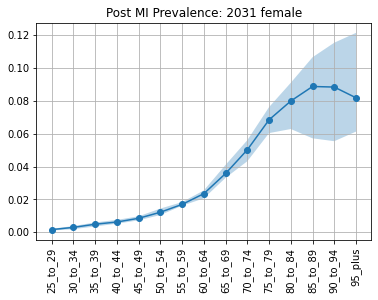

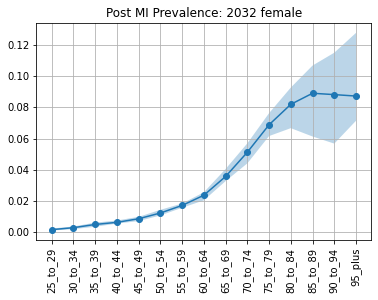

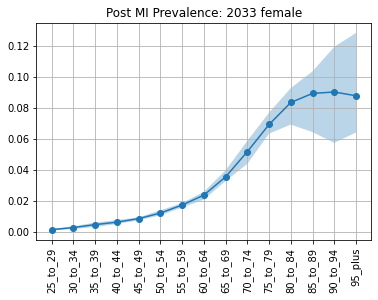

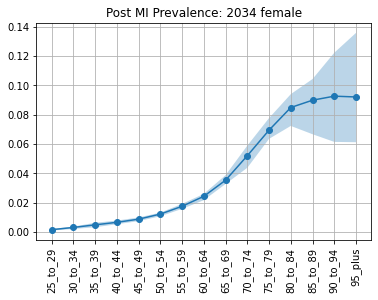

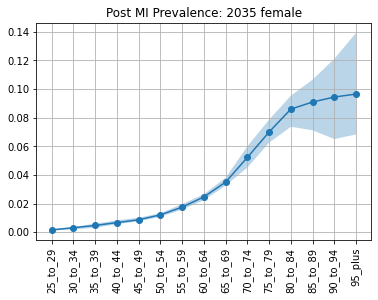

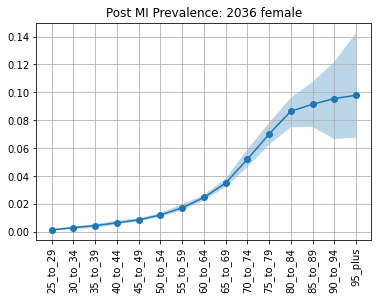

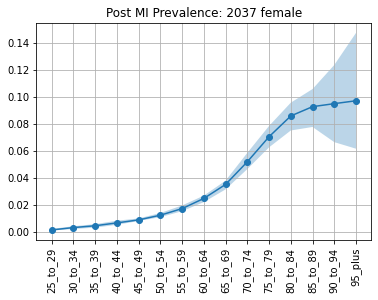

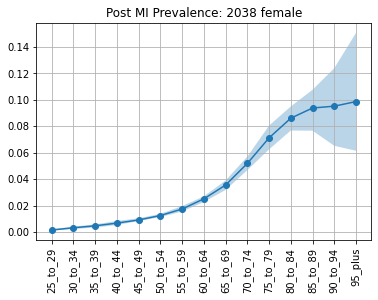

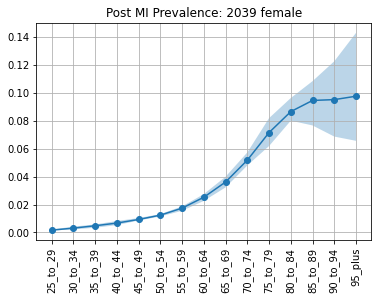

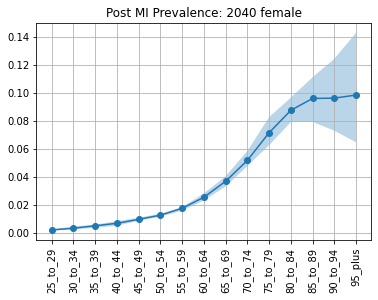

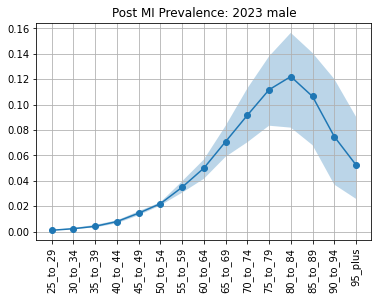

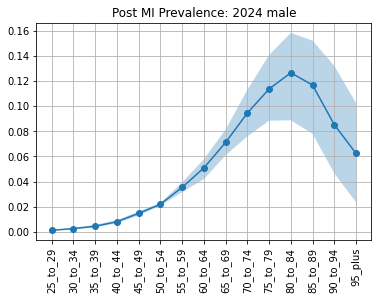

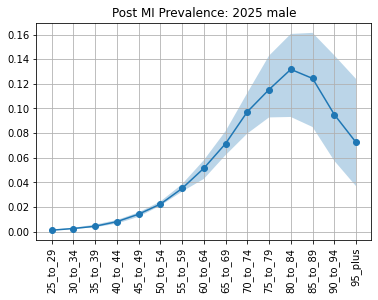

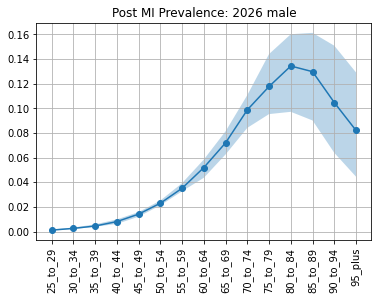

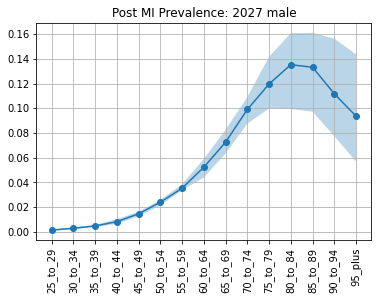

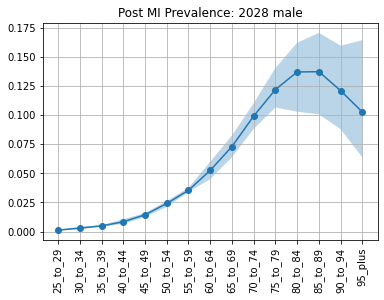

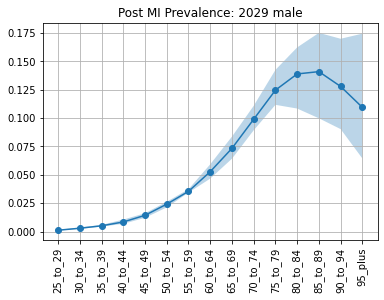

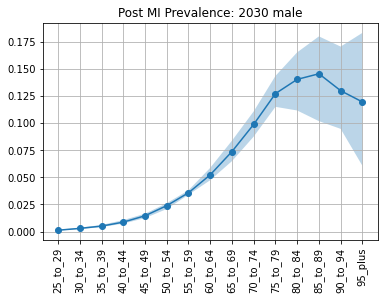

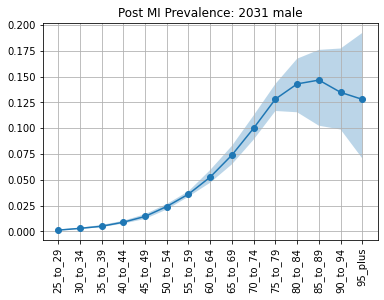

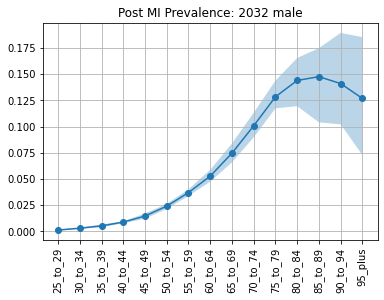

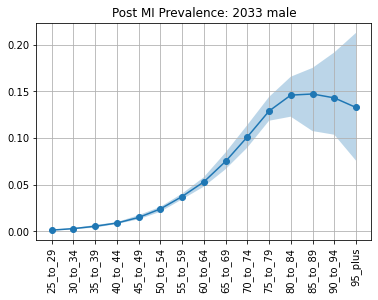

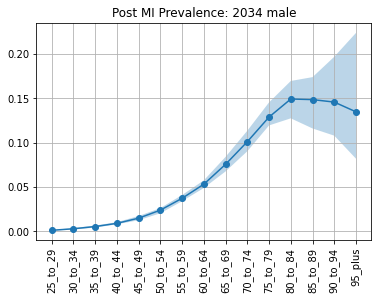

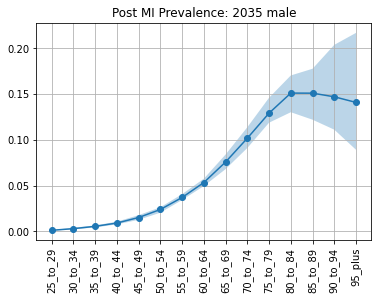

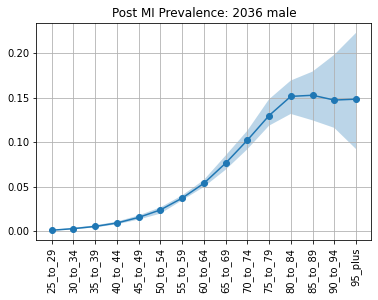

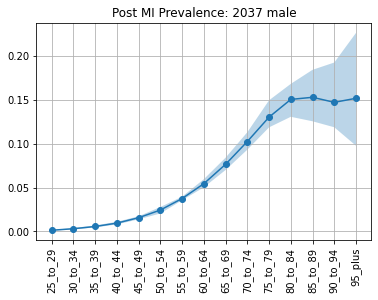

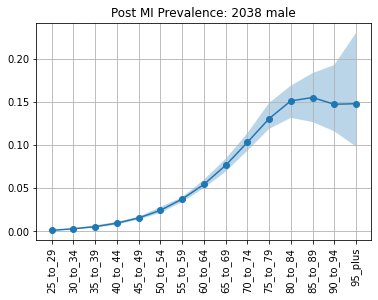

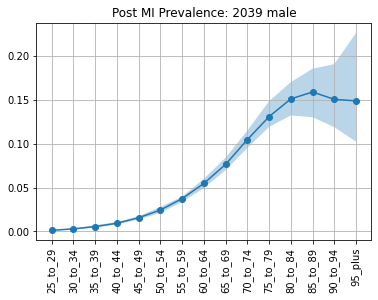

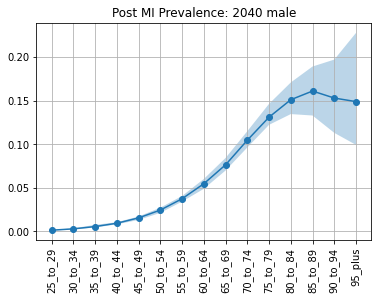

In [340]:
#%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [85]:
##You see the same kinda weird thing going on with the later years/older age groups as noted above

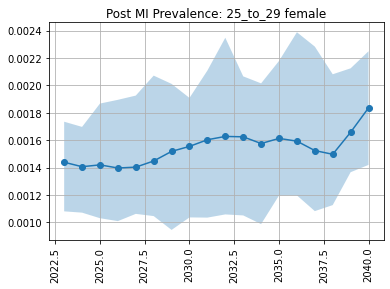

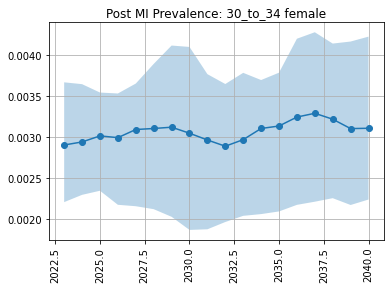

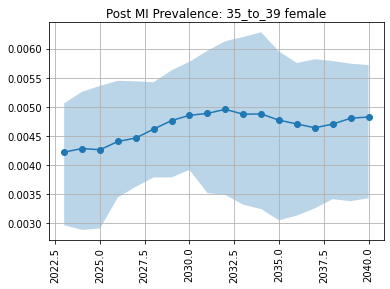

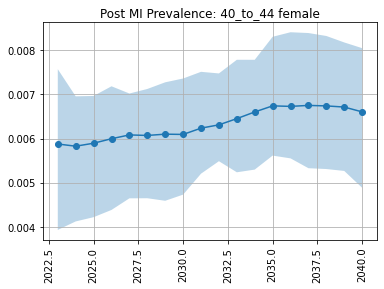

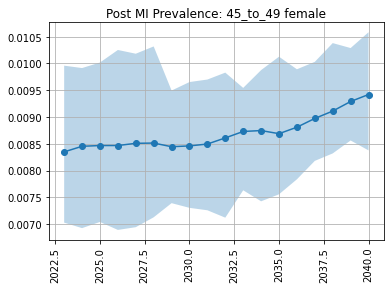

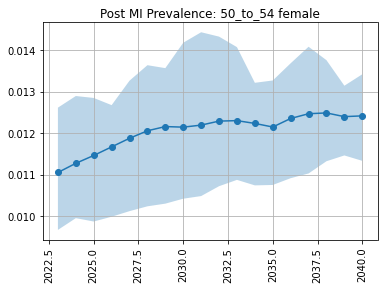

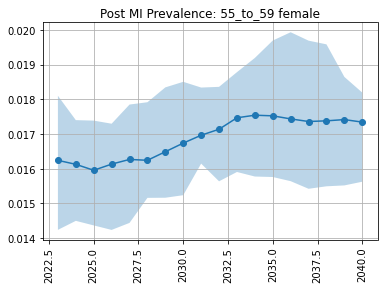

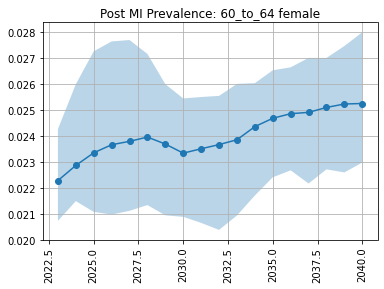

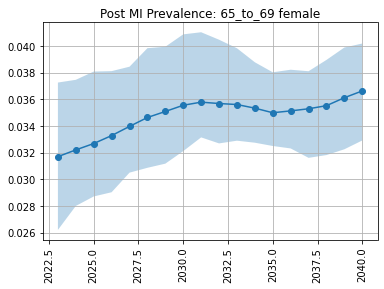

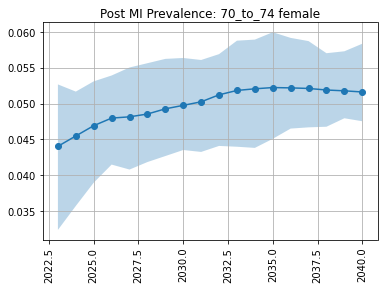

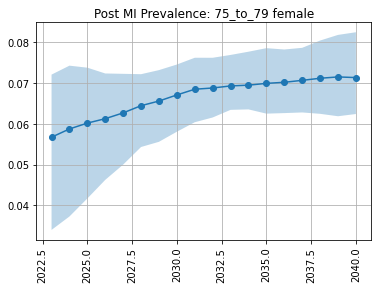

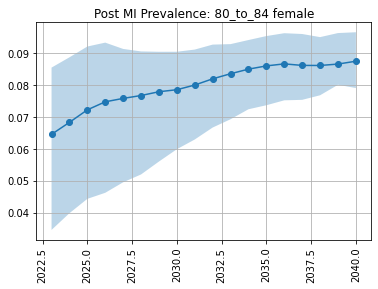

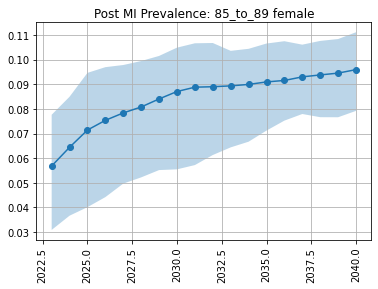

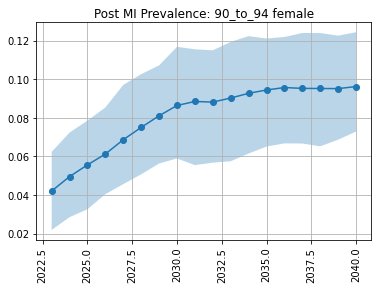

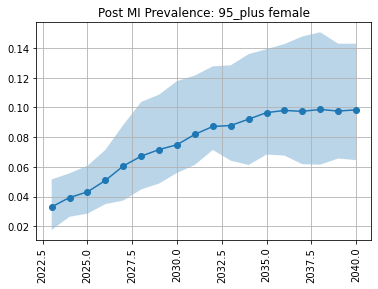

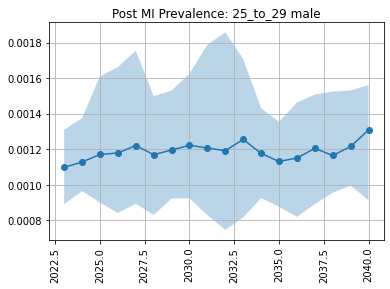

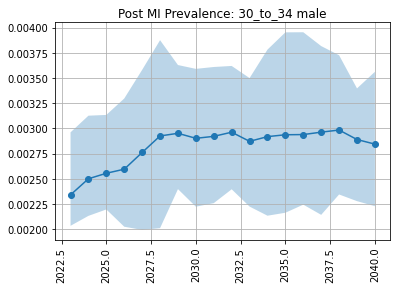

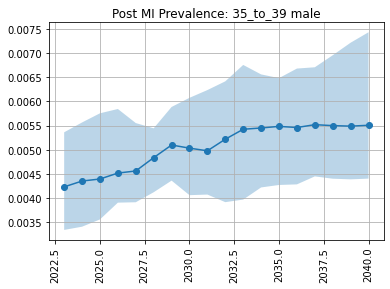

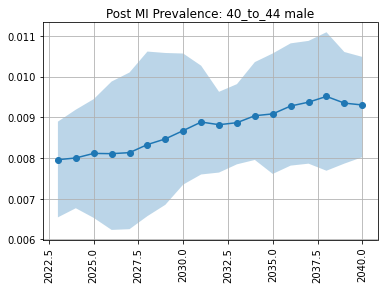

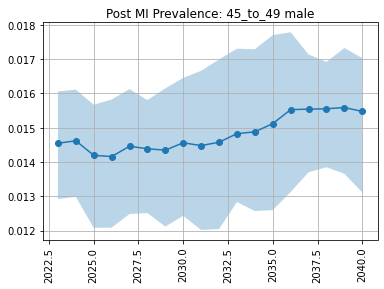

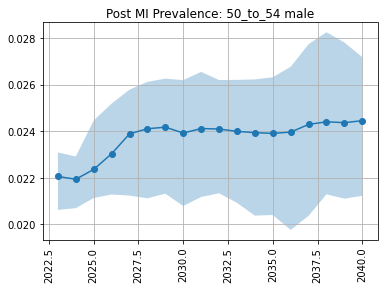

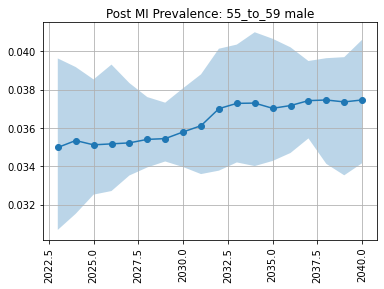

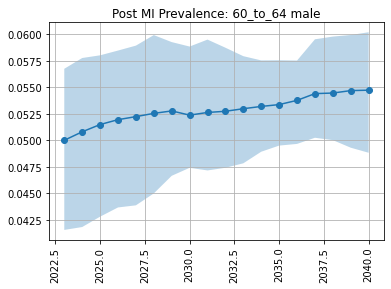

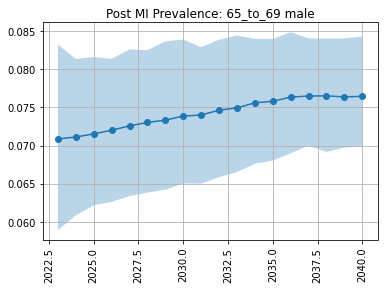

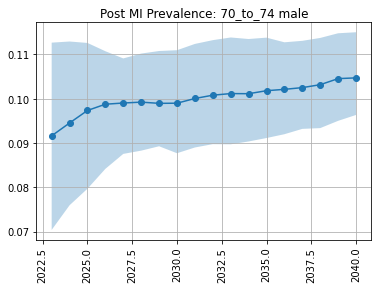

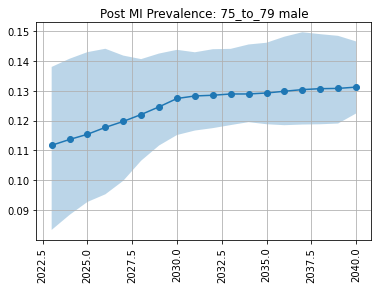

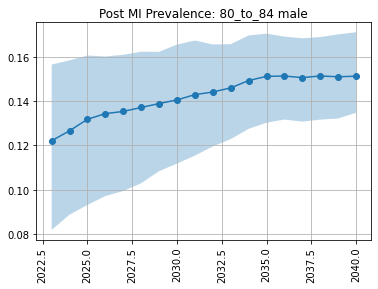

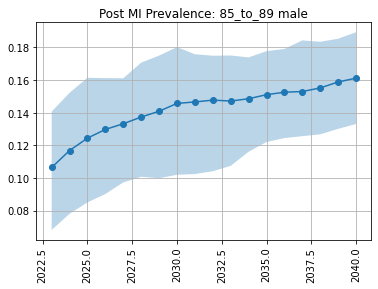

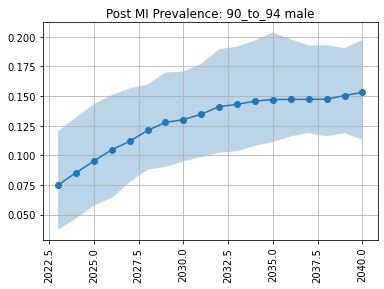

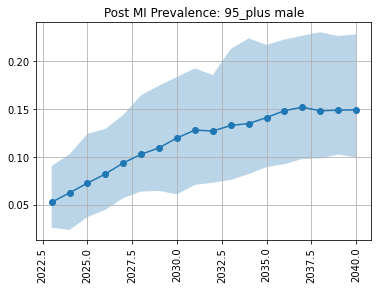

In [341]:
#%%capture
for sex in prev_post_MI_summ.sex.unique():
    for age in prev_post_MI_summ.age.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [88]:
##This seems to trend upwards. I am a bit concerned about it

##Still true, even more true now. This is a concern

In [344]:
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [349]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_post_hf = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_post_myocardial_infarction']))].reset_index()
tran_rate_post_to_hf = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_post_to_hf = tran_rate_post_to_hf.groupby(groupby_cols).sum() / per_time_sus_post_hf.groupby(groupby_cols).sum()
tran_rate_post_to_hf_summ = (tran_rate_post_to_hf.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_post_to_hf_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 female 2023   0.0   0.0    0.0
                2024   0.0   0.0    0.0
                2025   0.0   0.0    0.0
                2026   0.0   0.0    0.0
                2027   0.0   0.0    0.0

In [356]:
%%capture
for sex in tran_rate_post_to_hf_summ.index.get_level_values('sex').unique():
    for age in tran_rate_post_to_hf_summ.index.get_level_values('age').unique():
        plt.figure() 
        subdata = tran_rate_post_to_hf_summ.loc[(tran_rate_post_to_hf_summ.index.get_level_values('sex')==sex) & (tran_rate_post_to_hf_summ.index.get_level_values('age')==age)]
        plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('year'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI to HF Rate Incidence: {age} {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.ylim(0,0.04)

In [357]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_ami_post = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction']))].reset_index()
tran_rate_ami_to_post = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_ami_to_post = tran_rate_ami_to_post.groupby(groupby_cols).sum() / tran_rate_ami_to_post.groupby(groupby_cols).sum()
tran_rate_ami_to_post_summ = (tran_rate_ami_to_post.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_ami_to_post_summ.head()

mean  2.5%  97.5%
age      sex    year                   
25_to_29 female 2023   1.0   1.0    1.0
                2024   1.0   1.0    1.0
                2025   1.0   1.0    1.0
                2026   1.0   1.0    1.0
                2027   1.0   1.0    1.0

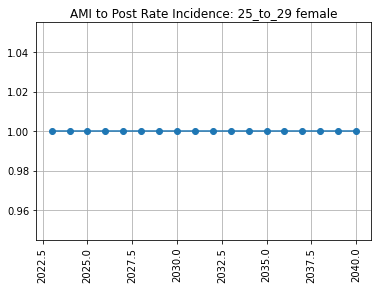

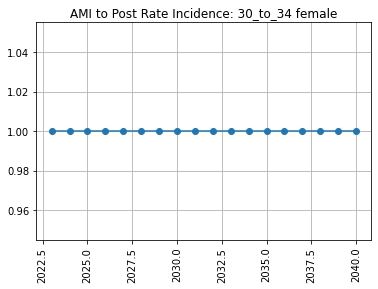

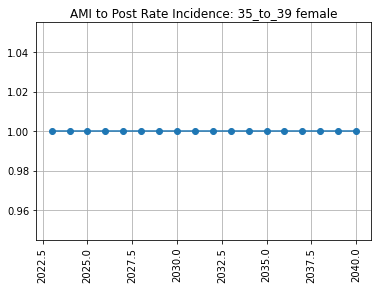

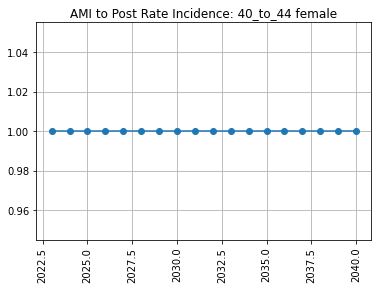

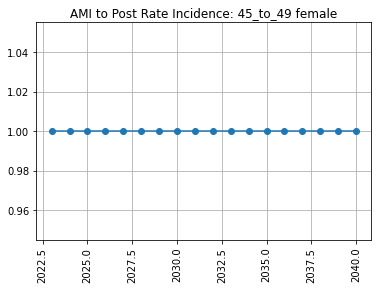

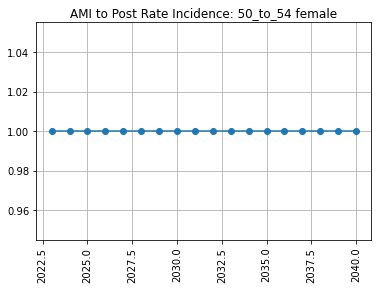

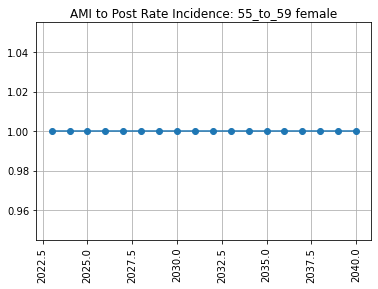

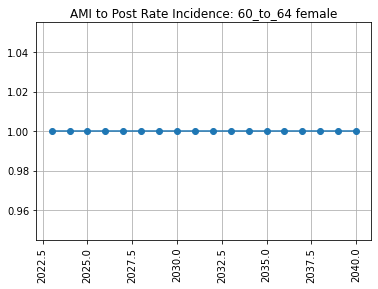

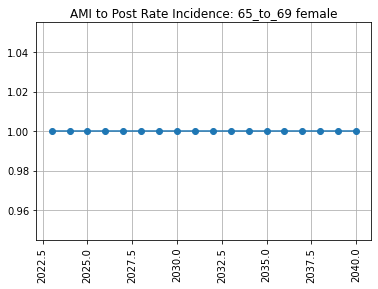

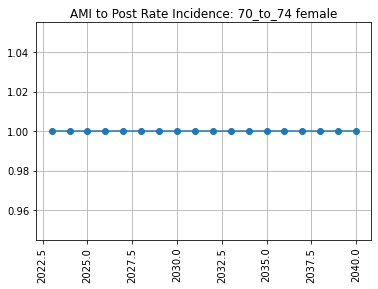

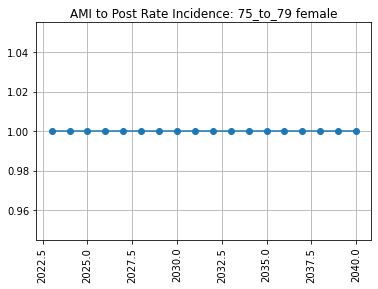

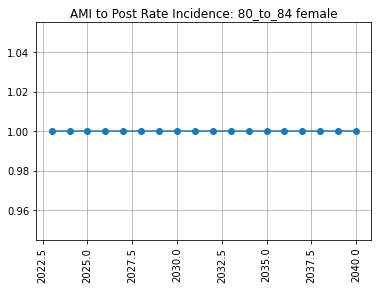

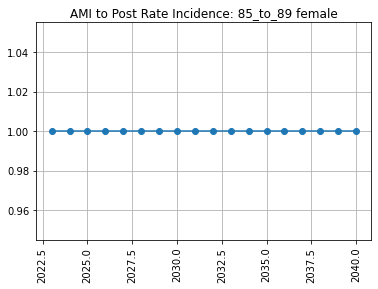

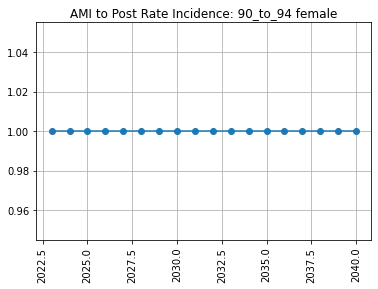

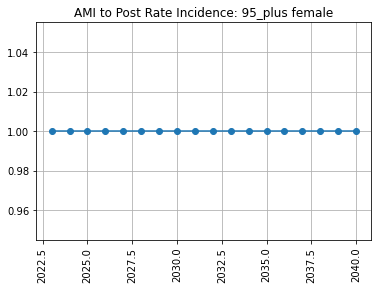

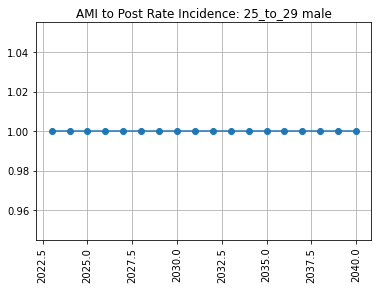

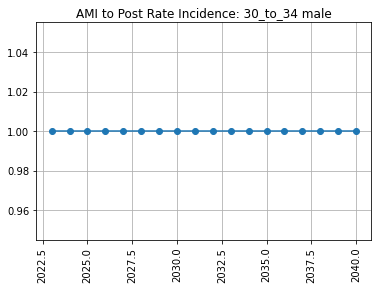

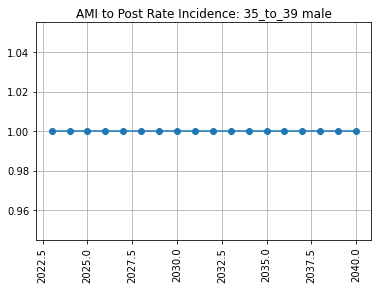

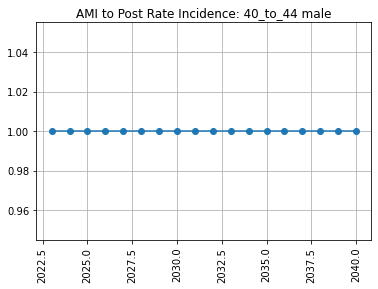

In [ ]:
#%%capture
for sex in tran_rate_ami_to_post_summ.index.get_level_values('sex').unique():
    for age in tran_rate_ami_to_post_summ.index.get_level_values('age').unique():
        plt.figure() 
        subdata = tran_rate_ami_to_post_summ.loc[(tran_rate_ami_to_post_summ.index.get_level_values('sex')==sex) & (tran_rate_ami_to_post_summ.index.get_level_values('age')==age)]
        plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('year'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'AMI to Post Rate Incidence: {age} {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.ylim(0,0.04)

### Prevalence of Heart Failure

In [206]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001426,0.000122,0.003272
1,25_to_29,female,2024,0.001403,0.000053,0.003481
2,25_to_29,female,2025,0.001385,0.000092,0.003371
3,25_to_29,female,2026,0.001363,0.000040,0.003398
4,25_to_29,female,2027,0.001406,0.000062,0.003495


In [209]:
%%capture
for sex in prev_HF_summ.sex.unique():
    for year in prev_HF_summ.year.unique():
        plt.figure() 
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [211]:
%%capture
for sex in prev_HF_summ.sex.unique():
    for age in prev_HF_summ.age.unique():
        plt.figure() 
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [89]:
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [90]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,10,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,3.5,1.000,6.775
1,21,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,3.7,1.000,7.550
2,32,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,3.3,1.000,8.325
3,43,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,3.0,0.225,7.775
4,54,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,2.5,0.000,4.000


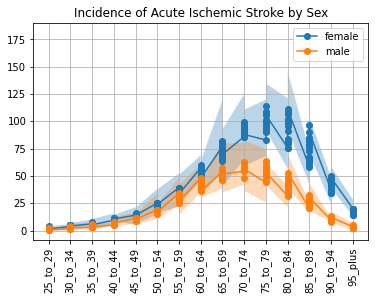

In [91]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [92]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,80,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,27312.668036
1,81,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,27676.572211
2,82,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,27508.533881
3,83,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,27338.502396
4,84,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,27301.092402


In [93]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000127,0.000036,0.000245
1,25_to_29,female,2024,0.000136,0.000036,0.000276
2,25_to_29,female,2025,0.000122,0.000037,0.000307
3,25_to_29,female,2026,0.000112,0.000008,0.000289
4,25_to_29,female,2027,0.000093,0.000000,0.000149


In [94]:
%%capture
with PdfPages('model11_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [95]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000393  0.000190  0.000602
                2024  0.000503  0.000311  0.000650
                2025  0.000422  0.000269  0.000632
                2026  0.000428  0.000261  0.000656
                2027  0.000471  0.000272  0.000722

In [96]:
%%capture
with PdfPages('model11_acute_MI_inc.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Incidence of Heart Failure 

In [224]:
tran['transition'].unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [225]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000771  0.000554  0.001069
                2024  0.000710  0.000399  0.001152
                2025  0.000738  0.000347  0.001064
                2026  0.000686  0.000382  0.001109
                2027  0.000661  0.000437  0.001058

In [227]:
%%capture
with PdfPages('model11_HF_inc.pdf') as pdf:
    for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
        for year in tran_rate_HF_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'HF Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Ratio in Prevalence of HF IHD to HF Resid 

In [335]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['IHD_rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_resid['resid_rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_ratio = prev_HF_IHD.merge(prev_HF_resid[['age','sex','year','input_draw','resid_rate']], on=['age','sex','year','input_draw'])
prev_HF_ratio['IHD_ratio'] = prev_HF_ratio['IHD_rate']/ (prev_HF_ratio['IHD_rate'] + prev_HF_ratio['resid_rate'])
prev_HF_ratio_summ = (prev_HF_ratio
                 .groupby(['age', 'sex', 'year'])
                 .IHD_ratio.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_ratio_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.073879,0.034368,0.111353
1,25_to_29,female,2024,0.060057,0.017056,0.088908
2,25_to_29,female,2025,0.064804,0.031544,0.096483
3,25_to_29,female,2026,0.060896,0.011845,0.097474
4,25_to_29,female,2027,0.062980,0.015247,0.112935


In [337]:
%%capture
for sex in prev_HF_ratio_summ.sex.unique():
    for age in prev_HF_ratio_summ.age.unique():
        plt.figure() 
        subdata = prev_HF_ratio_summ.loc[(prev_HF_ratio_summ.sex==sex) & (prev_HF_ratio_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Ratio the is IHD Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

In [339]:
%%capture
for sex in prev_HF_ratio_summ.sex.unique():
    for year in prev_HF_ratio_summ.year.unique():
        plt.figure() 
        subdata = prev_HF_ratio_summ.loc[(prev_HF_ratio_summ.sex==sex) & (prev_HF_ratio_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'HF Ratio that is IHD Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

### Artifacts

In [97]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  raw_data/  washington.hdf


In [98]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [99]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [100]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [101]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [102]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [103]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [104]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000983,0.000553,0.001532
1,25_to_29,male,0.002218,0.001563,0.003005
2,30_to_34,female,0.001344,0.000896,0.001871
3,30_to_34,male,0.002437,0.001764,0.003118
4,35_to_39,female,0.001747,0.001170,0.002383


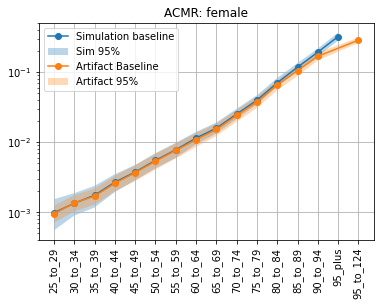

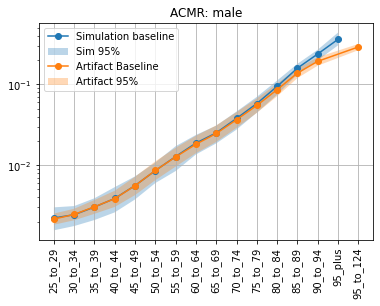

In [105]:
with PdfPages('model11_acmr_artifact_and_sim.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [106]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [107]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [108]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [109]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [110]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000003,0.0,0.000038
1,25_to_29,male,0.000001,0.0,0.000037
2,30_to_34,female,0.000005,0.0,0.000057
3,30_to_34,male,0.000004,0.0,0.000038
4,35_to_39,female,0.000007,0.0,0.000038


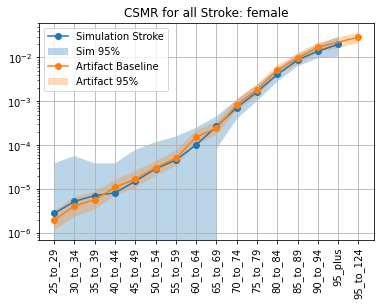

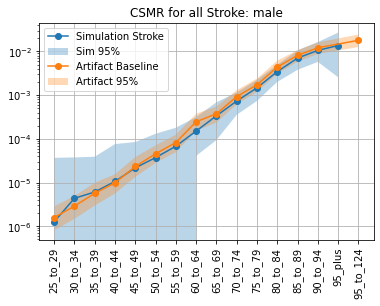

In [111]:
with PdfPages('model11_csmr_artifact_and_sim.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### IHD and HF Combined

In [257]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000546,0.000412,0.000710,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000652,0.000483,0.000838,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000746,0.000545,0.000978,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000804,0.000611,0.001051,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.001383,0.001112,0.001699,Alabama,cause_specific_mortality_rate,45_to_49


In [258]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [263]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000592,0.000298,0.001021
1,25_to_29,male,0.000882,0.000459,0.001434
2,30_to_34,female,0.000637,0.000351,0.001007
3,30_to_34,male,0.000964,0.000550,0.001429
...,...,...,...,...,...
26,90_to_94,female,0.122149,0.089220,0.148648
27,90_to_94,male,0.190582,0.139920,0.239278
28,95_plus,female,0.172211,0.120487,0.227163
29,95_plus,male,0.267630,0.190355,0.359612


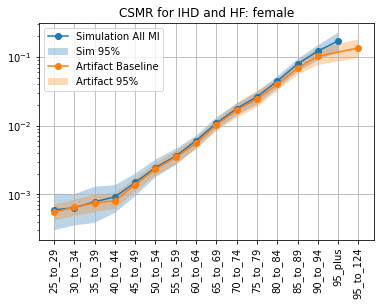

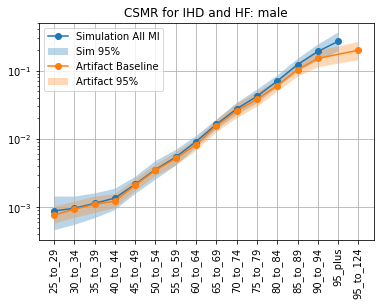

In [264]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [137]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [138]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000102,0.000000,0.000272
1,25_to_29,male,0.000055,0.000000,0.000220
2,30_to_34,female,0.000161,0.000036,0.000344
3,30_to_34,male,0.000094,0.000000,0.000276
4,35_to_39,female,0.000234,0.000038,0.000539


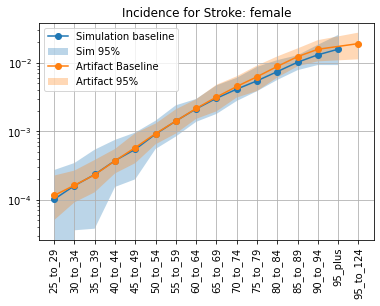

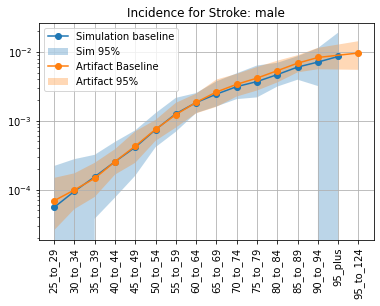

In [139]:
with PdfPages('model11_inc_artifact_and_sim.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        pdf.savefig(bbox_inches='tight')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [140]:
art_inc_acute_MI = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000452,0.000284,0.000616,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000510,0.000345,0.000683,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000426,0.000296,0.000581,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000540,0.000414,0.000690,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000850,0.000649,0.001110,Alabama,incidence_rate,45_to_49


In [141]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000449  0.000300  0.000596
         male    0.000446  0.000328  0.000565
30_to_34 female  0.000514  0.000334  0.000664
         male    0.000659  0.000504  0.000844
35_to_39 female  0.000467  0.000359  0.000593

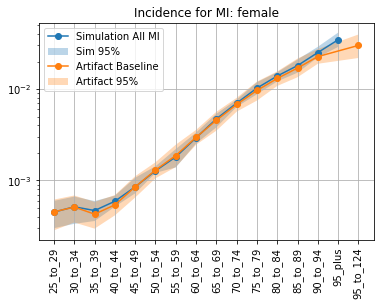

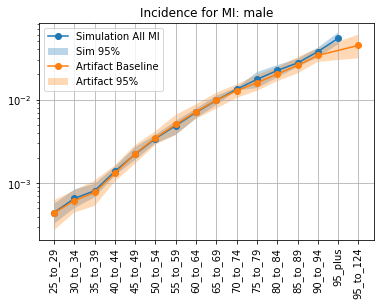

In [142]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure IHD

In [235]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000057,0.000041,0.000075,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000081,0.000060,0.000104,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000089,0.000056,0.000130,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000185,0.000138,0.000239,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000497,0.000408,0.000590,Alabama,incidence_rate,45_to_49


In [236]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000057  0.000038  0.000089
         male    0.000136  0.000095  0.000169
30_to_34 female  0.000087  0.000049  0.000126
         male    0.000193  0.000144  0.000235
35_to_39 female  0.000106  0.000072  0.000137

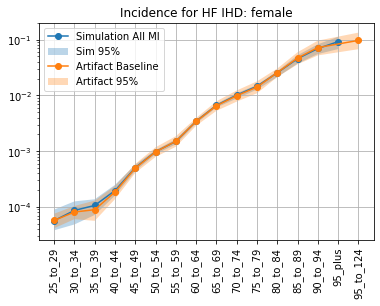

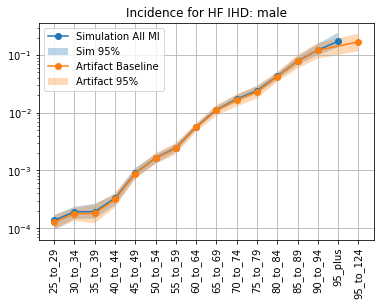

In [237]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [239]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000601,0.000435,0.000792,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000568,0.000423,0.000728,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000395,0.000249,0.000574,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000683,0.000509,0.000880,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.001313,0.001078,0.001558,Alabama,incidence_rate,45_to_49


In [240]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000640  0.000413  0.000848
         male    0.000940  0.000714  0.001096
30_to_34 female  0.000586  0.000403  0.000717
         male    0.000846  0.000664  0.001044
35_to_39 female  0.000447  0.000351  0.000520

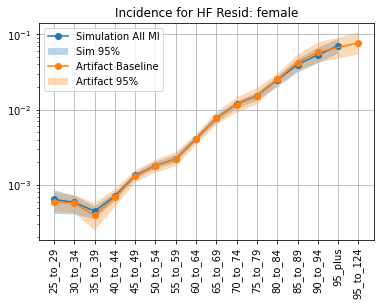

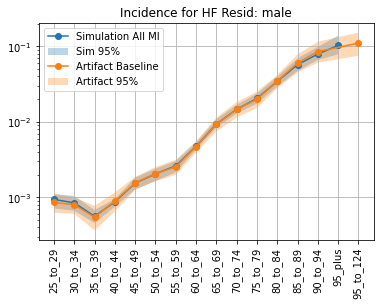

In [241]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [143]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [144]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


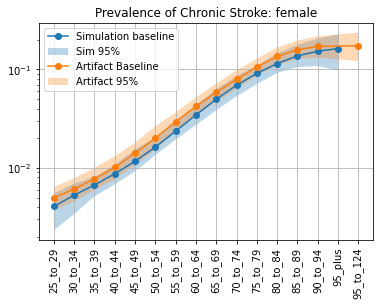

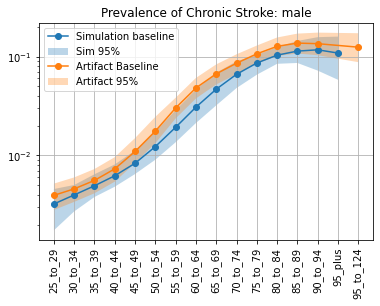

In [145]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [146]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [147]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

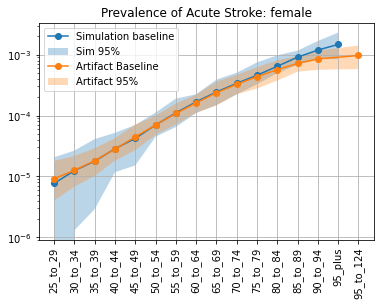

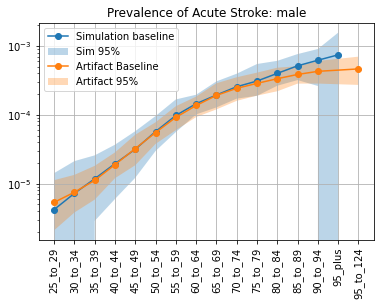

In [148]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [149]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [150]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001541,0.001013,0.002218
1,25_to_29,male,0.001188,0.000815,0.001671
2,30_to_34,female,0.003066,0.001889,0.004168
3,30_to_34,male,0.002820,0.002075,0.003840
4,35_to_39,female,0.004662,0.002908,0.005986


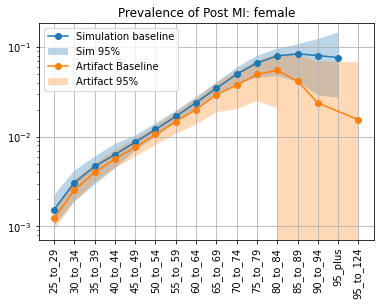

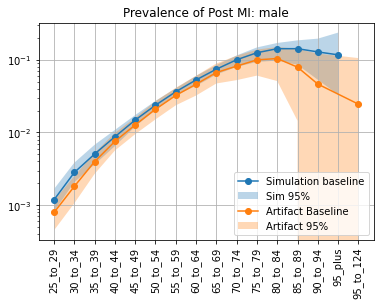

In [151]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Acute MI

In [152]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000022,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [273]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000034,0.000015,0.000063
1,25_to_29,male,0.000034,0.000014,0.000057
2,30_to_34,female,0.000039,0.000018,0.000068
3,30_to_34,male,0.000050,0.000026,0.000082
4,35_to_39,female,0.000036,0.000017,0.000061


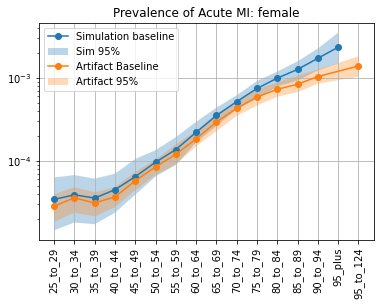

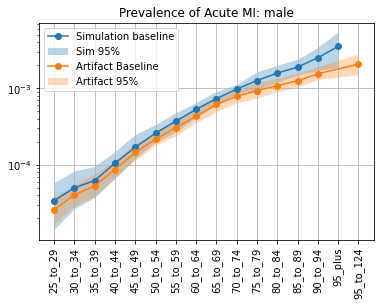

In [274]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [213]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ihd', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000169,0.000080,0.000298,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000376,0.000216,0.000611,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000471,0.000237,0.000849,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000545,0.000286,0.000963,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.001123,0.000589,0.002021,Alabama,prevalence,45_to_49


In [242]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000171,0.000042,0.000311
1,25_to_29,male,0.000384,0.000139,0.000672
2,30_to_34,female,0.000367,0.000119,0.000669
3,30_to_34,male,0.000761,0.000486,0.001093
4,35_to_39,female,0.000513,0.000231,0.000857


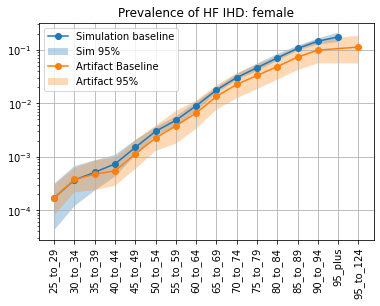

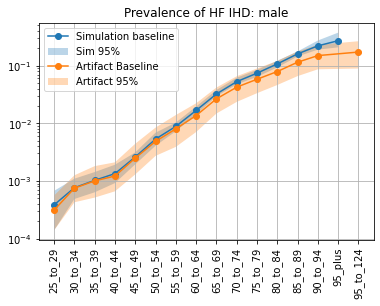

In [243]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [214]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.002341,0.001774,0.003021,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.003290,0.002414,0.004362,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.002993,0.002267,0.003813,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.002735,0.002134,0.003475,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.004126,0.003504,0.004772,Alabama,prevalence,45_to_49


In [244]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_resid_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.002453,0.001707,0.003564
1,25_to_29,male,0.003223,0.002306,0.004087
2,30_to_34,female,0.003377,0.002368,0.005272
3,30_to_34,male,0.004408,0.003306,0.005824
4,35_to_39,female,0.003417,0.002409,0.004699


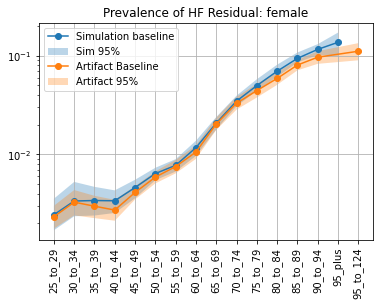

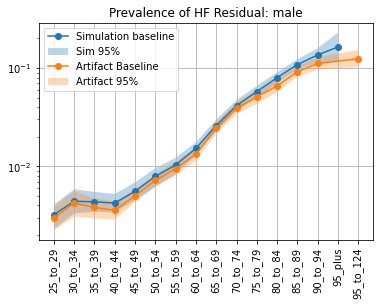

In [245]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [155]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [169]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.390259,0.0,4.348214
1,25_to_29,male,0.280530,0.0,3.261161
2,30_to_34,female,0.414204,0.0,4.348214
3,30_to_34,male,0.608468,0.0,6.522321
4,35_to_39,female,0.289464,0.0,2.608929


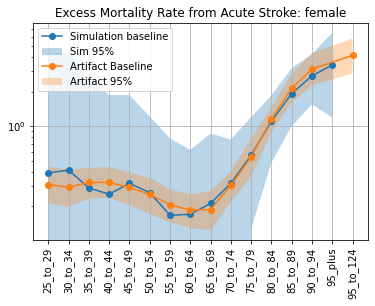

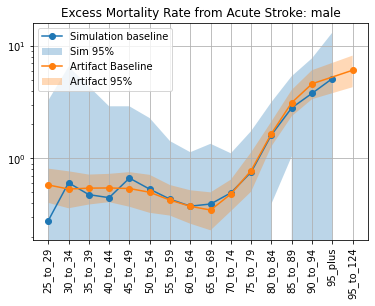

In [170]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [158]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [159]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000041,0.0,0.00000
1,25_to_29,male,0.000000,0.0,0.00000
2,30_to_34,female,0.000080,0.0,0.00000
3,30_to_34,male,0.000087,0.0,0.00000
4,35_to_39,female,0.000187,0.0,0.00497


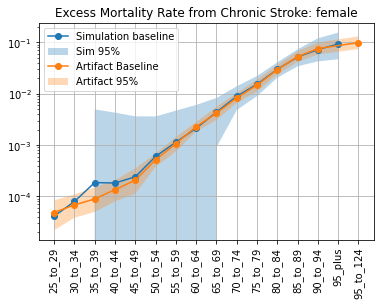

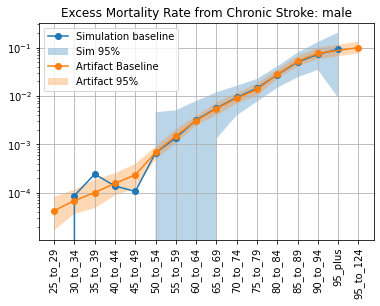

In [160]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [161]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [203]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction',
       'acute_myocardial_infarction_and_heart_failure',
       'chronic_ischemic_stroke',
       'heart_failure_from_ischemic_heart_disease',
       'heart_failure_residual', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [269]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','ptvalue']], on=['age','year','sex','input_draw'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.496972,0.0,6.079735
1,25_to_29,male,3.920759,0.0,7.535611
2,30_to_34,female,2.012713,0.0,5.217857
3,30_to_34,male,2.593089,0.0,4.916447
4,35_to_39,female,1.706861,0.0,4.348214


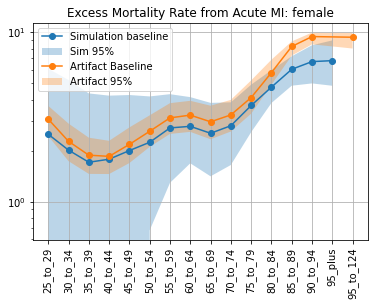

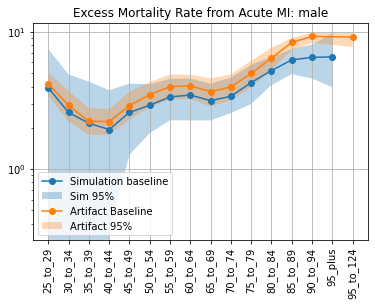

In [270]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [164]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.050404,0.0,0.136578
1,25_to_29,male,0.055754,0.0,0.152928
2,30_to_34,female,0.023832,0.0,0.066268
3,30_to_34,male,0.026799,0.0,0.069223
4,35_to_39,female,0.016647,0.0,0.047521


In [165]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

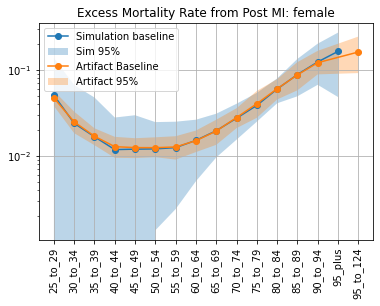

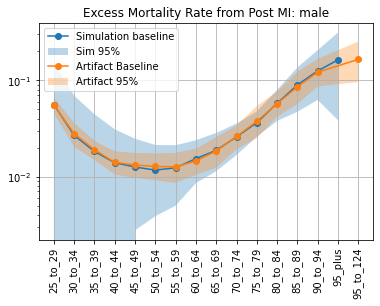

In [253]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [250]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.157219,0.111406,0.216535,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.136440,0.095899,0.187640,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.169535,0.122948,0.222670,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.192198,0.141037,0.254912,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.204429,0.163795,0.255060,Alabama,excess_mortality_rate,45_to_49


In [252]:
HF_emr_allyear = (HF_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


HF_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,inf,0.000000,5.417845
1,25_to_29,male,0.542061,0.000000,2.746241
2,30_to_34,female,0.417932,0.000000,2.174645
3,30_to_34,male,0.303393,0.007535,1.310149
4,35_to_39,female,0.385472,0.000000,1.865972


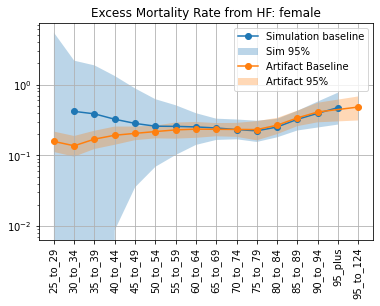

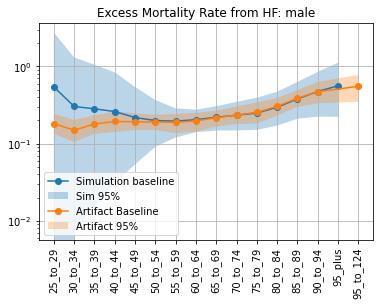

In [254]:
for sex in HF_emr_allyear.sex.unique():
    plt.figure() 
    subdata = HF_emr_allyear.loc[(HF_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_HF.loc[(art_emr_HF.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Looks a little wild in the youngest age groups but I think this is likely just due to very small sample sizes 

# GBD Comparison

#### All Cause Mortality Rate

In [175]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [176]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,294,523,1,3,1,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002153,0.002516,0.001834,25_to_29
1,10,294,523,1,3,2,2019,_all,25 to 29,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.000950,0.001237,0.000706,25_to_29
2,11,294,523,1,3,1,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.002456,0.002887,0.002079,30_to_34
3,11,294,523,1,3,2,2019,_all,30 to 34,All causes,False,Alabama,admin1,Deaths,Rate,Female,0.001364,0.001755,0.001029,30_to_34
4,12,294,523,1,3,1,2019,_all,35 to 39,All causes,False,Alabama,admin1,Deaths,Rate,Male,0.003056,0.003710,0.002501,35_to_39


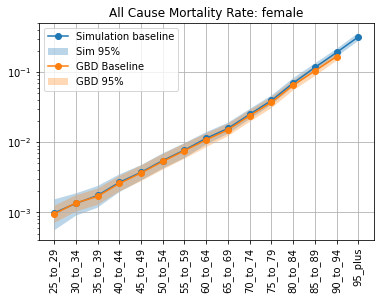

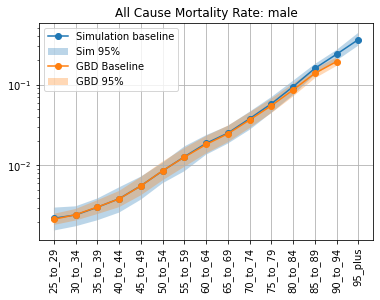

In [342]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [178]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [179]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,495,523,6,3,1,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000068,0.000147,0.000025,25_to_29
1,10,495,523,6,3,2,2019,cvd_stroke_isch,25 to 29,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000115,0.000224,0.000050,25_to_29
2,11,495,523,6,3,1,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000098,0.000171,0.000052,30_to_34
3,11,495,523,6,3,2,2019,cvd_stroke_isch,30 to 34,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Female,0.000162,0.000265,0.000091,30_to_34
4,12,495,523,6,3,1,2019,cvd_stroke_isch,35 to 39,Ischemic stroke,False,Alabama,admin1,Incidence,Rate,Male,0.000145,0.000243,0.000077,35_to_39


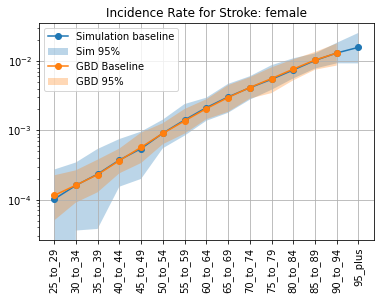

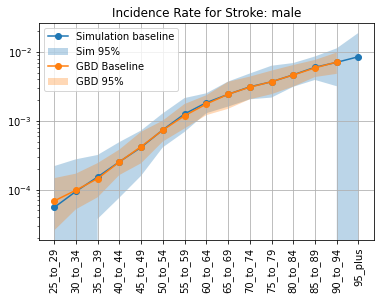

In [180]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [181]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,6,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000441,0.000626,0.000274,25_to_29
1,10,493,523,6,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000452,0.000616,0.000284,25_to_29
2,11,493,523,6,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000621,0.000818,0.000448,30_to_34
3,11,493,523,6,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Female,0.000510,0.000683,0.000345,30_to_34
4,12,493,523,6,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,Incidence,Rate,Male,0.000777,0.001081,0.000536,35_to_39


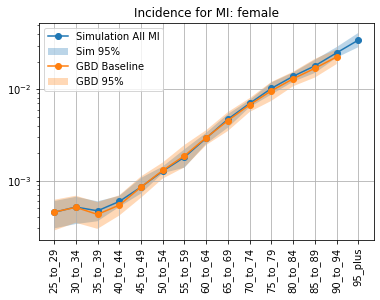

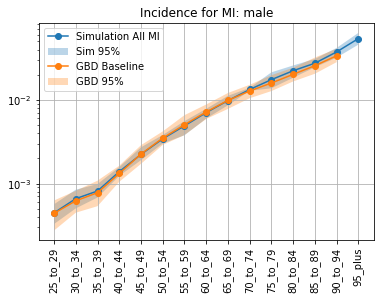

In [182]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [187]:
tran.transition.unique()

array(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_to_post_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease',
       'ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_diseas

In [188]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000449,0.000196,0.000797
1,25_to_29,male,0.000444,0.000181,0.000741
2,30_to_34,female,0.000512,0.000234,0.000867
3,30_to_34,male,0.000656,0.000332,0.001045
4,35_to_39,female,0.000465,0.000228,0.000794


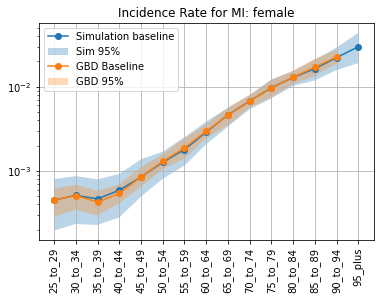

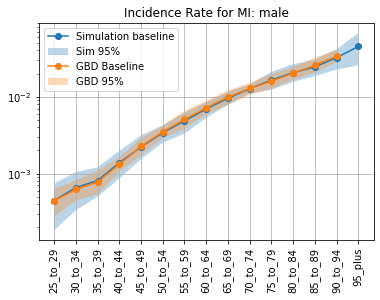

In [189]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Acute MI

In [190]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=523, year_id=2019, sex_id=[1,2], decomp_step='step5')

In [191]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

,age_group_id,cause_id,location_id,measure_id,metric_id,sex_id,year_id,acause,age_group_name,cause_name,expected,location_name,location_type,measure_name,metric_name,sex,val,upper,lower,age
0,10,493,523,2,3,1,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.002084,0.002684,0.001595,25_to_29
1,10,493,523,2,3,2,2019,cvd_ihd,25 to 29,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.001076,0.001488,0.000753,25_to_29
2,11,493,523,2,3,1,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.005151,0.006505,0.003896,30_to_34
3,11,493,523,2,3,2,2019,cvd_ihd,30 to 34,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Female,0.002720,0.003687,0.001977,30_to_34
4,12,493,523,2,3,1,2019,cvd_ihd,35 to 39,Ischemic heart disease,False,Alabama,admin1,DALYs (Disability-Adjusted Life Years),Rate,Male,0.012157,0.015460,0.009483,35_to_39


In [192]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yll_MI)

5400

In [193]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

,age,sex,year,input_draw,yll,yld,daly
0,25_to_29,female,2023,29,311.989557,0.052459,312.042015
1,25_to_29,female,2023,232,242.322588,0.104918,242.427506
2,25_to_29,female,2023,357,183.463117,0.096175,183.559291
3,25_to_29,female,2023,394,306.749258,0.087431,306.836689
4,25_to_29,female,2023,602,311.424912,0.192349,311.617261


In [194]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.009815,0.001101,0.019825
1,25_to_29,male,0.012289,0.003008,0.024705
2,30_to_34,female,0.008426,0.002076,0.016799
3,30_to_34,male,0.011631,0.003090,0.021898
4,35_to_39,female,0.007183,0.001885,0.017427


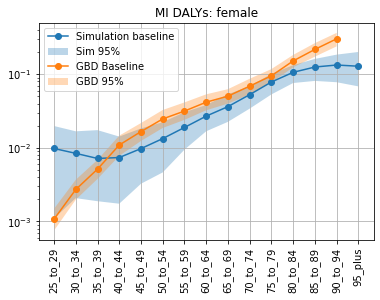

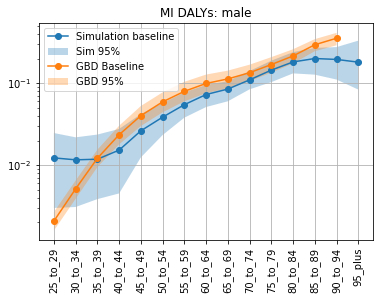

In [195]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Incidence of Heart Failure (need to be overall)

In [319]:
gbd_hf_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 6,
         metric_id = 3,
         source='epi')

In [320]:
gbd_hf_inc_data = gbd_hf_inc.iloc[:,1:1001].apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
gbd_hf_inc = pd.concat([gbd_hf_inc, gbd_hf_inc_data], axis=1)
gbd_hf_inc['age_group'] = np.where(gbd_hf_inc['age_group_id']==10,'25_to_29',np.where(gbd_hf_inc['age_group_id']==11,'30_to_34',np.where(gbd_hf_inc['age_group_id']==12,'35_to_39',np.where(gbd_hf_inc['age_group_id']==13,'40_to_44',np.where(gbd_hf_inc['age_group_id']==14,'45_to_49',np.where(gbd_hf_inc['age_group_id']==15,'50_to_54',np.where(gbd_hf_inc['age_group_id']==16,'55_to_59',np.where(gbd_hf_inc['age_group_id']==17,'60_to_64',np.where(gbd_hf_inc['age_group_id']==18,'65_to_69',np.where(gbd_hf_inc['age_group_id']==19,'70_to_74',np.where(gbd_hf_inc['age_group_id']==20,'75_to_79',np.where(gbd_hf_inc['age_group_id']==30,'80_to_84',np.where(gbd_hf_inc['age_group_id']==31,'85_to_89',np.where(gbd_hf_inc['age_group_id']==32,'90_to_94',0))))))))))))))
gbd_hf_inc['sex'] = np.where(gbd_hf_inc['sex_id']==1,'male','female')
gbd_hf_inc

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,year_id,metric_id,model_version_id,modelable_entity_id,index,mean,2.5%,97.5%,age_group,sex
0,10,0.000580,0.000645,0.000652,0.000764,0.000696,0.000682,0.000654,0.000598,0.000591,...,2019,3,474434,2412,0,0.000654,0.000474,0.000861,25_to_29,female
1,11,0.000560,0.000678,0.000653,0.000726,0.000681,0.000636,0.000672,0.000580,0.000584,...,2019,3,474434,2412,1,0.000643,0.000479,0.000823,30_to_34,female
2,12,0.000393,0.000596,0.000531,0.000463,0.000533,0.000376,0.000585,0.000417,0.000436,...,2019,3,474434,2412,2,0.000479,0.000302,0.000696,35_to_39,female
3,13,0.000739,0.000970,0.000866,0.000735,0.001012,0.000783,0.000880,0.000950,0.000795,...,2019,3,474434,2412,3,0.000859,0.000639,0.001106,40_to_44,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,20,0.034810,0.026173,0.025815,0.039883,0.029950,0.030561,0.028690,0.036332,0.031442,...,2019,3,474434,2412,24,0.031995,0.024954,0.039942,75_to_79,male
25,30,0.056762,0.045549,0.040194,0.057717,0.047708,0.048105,0.050991,0.057631,0.049395,...,2019,3,474434,2412,25,0.051916,0.042305,0.061660,80_to_84,male
26,31,0.087391,0.073970,0.061637,0.080458,0.073133,0.073803,0.082938,0.087029,0.074230,...,2019,3,474434,2412,26,0.080312,0.062431,0.100092,85_to_89,male
27,32,0.112624,0.097711,0.081192,0.098915,0.094516,0.096933,0.108672,0.110924,0.094541,...,2019,3,474434,2412,27,0.104392,0.079426,0.134527,90_to_94,male


In [309]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000696  0.000456  0.000933
         male    0.001075  0.000809  0.001230
30_to_34 female  0.000671  0.000451  0.000837
         male    0.001037  0.000806  0.001238
35_to_39 female  0.000551  0.000436  0.000654

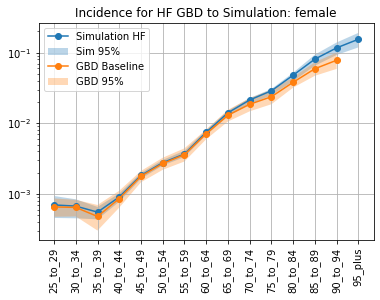

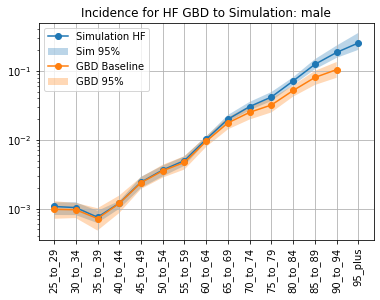

In [321]:
for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = gbd_hf_inc.loc[(gbd_hf_inc.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF GBD to Simulation: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation HF', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Prevalence of Heart Failure

In [322]:
gbd_hf_prev = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 5,
         metric_id = 3,
         source='epi')

In [323]:
gbd_hf_prev_data = gbd_hf_prev.iloc[:,1:1001].apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
gbd_hf_prev = pd.concat([gbd_hf_prev, gbd_hf_prev_data], axis=1)
gbd_hf_prev['age_group'] = np.where(gbd_hf_prev['age_group_id']==10,'25_to_29',np.where(gbd_hf_prev['age_group_id']==11,'30_to_34',np.where(gbd_hf_prev['age_group_id']==12,'35_to_39',np.where(gbd_hf_prev['age_group_id']==13,'40_to_44',np.where(gbd_hf_prev['age_group_id']==14,'45_to_49',np.where(gbd_hf_prev['age_group_id']==15,'50_to_54',np.where(gbd_hf_prev['age_group_id']==16,'55_to_59',np.where(gbd_hf_prev['age_group_id']==17,'60_to_64',np.where(gbd_hf_prev['age_group_id']==18,'65_to_69',np.where(gbd_hf_prev['age_group_id']==19,'70_to_74',np.where(gbd_hf_prev['age_group_id']==20,'75_to_79',np.where(gbd_hf_prev['age_group_id']==30,'80_to_84',np.where(gbd_hf_prev['age_group_id']==31,'85_to_89',np.where(gbd_hf_prev['age_group_id']==32,'90_to_94',0))))))))))))))
gbd_hf_prev['sex'] = np.where(gbd_hf_prev['sex_id']==1,'male','female')
gbd_hf_prev

,age_group_id,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,draw_103,draw_104,draw_105,...,year_id,metric_id,model_version_id,modelable_entity_id,index,mean,2.5%,97.5%,age_group,sex
0,10,0.002602,0.002432,0.002289,0.002948,0.002625,0.002922,0.002295,0.002586,0.002454,...,2019,3,474434,2412,0,0.002565,0.001943,0.003309,25_to_29,female
1,11,0.003730,0.003362,0.003287,0.004099,0.003751,0.004369,0.003254,0.003637,0.003456,...,2019,3,474434,2412,1,0.003761,0.002759,0.004986,30_to_34,female
2,12,0.003570,0.003483,0.003662,0.004097,0.003479,0.003984,0.003749,0.003560,0.003383,...,2019,3,474434,2412,2,0.003672,0.002782,0.004679,35_to_39,female
3,13,0.003256,0.003702,0.004112,0.003935,0.003278,0.003298,0.004402,0.003590,0.003268,...,2019,3,474434,2412,3,0.003482,0.002716,0.004423,40_to_44,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,20,0.112510,0.109840,0.115690,0.118510,0.107500,0.112420,0.115820,0.121190,0.118430,...,2019,3,474434,2412,24,0.117334,0.099809,0.137511,75_to_79,male
25,30,0.148220,0.149990,0.159450,0.149970,0.148380,0.149230,0.157900,0.163240,0.158390,...,2019,3,474434,2412,25,0.156597,0.134990,0.182642,80_to_84,male
26,31,0.217350,0.221070,0.213370,0.208870,0.214470,0.202890,0.237280,0.235780,0.225920,...,2019,3,474434,2412,26,0.221997,0.197069,0.250608,85_to_89,male
27,32,0.281140,0.283330,0.254370,0.270000,0.273960,0.246420,0.307470,0.301880,0.289700,...,2019,3,474434,2412,27,0.279154,0.241288,0.323885,90_to_94,male


In [324]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.002624,0.001851,0.003746
1,25_to_29,male,0.003607,0.002596,0.004448
2,30_to_34,female,0.003745,0.002527,0.005926
3,30_to_34,male,0.005169,0.003918,0.006604
4,35_to_39,female,0.003930,0.002814,0.005315


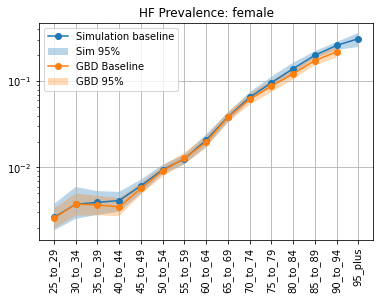

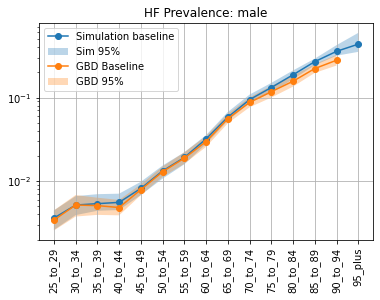

In [328]:
for sex in prev_HF_summ.sex.unique():
    plt.figure() 
    subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_hf_prev.loc[(gbd_hf_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'HF Prevalence: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 